In [1]:
#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Column 1: age in years
# Column 2: 1 = male, 0 = female
# Column 3: 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic
# Column 4: resting blood pressure in mmHg
# Column 5: cholesterol in mg/dl
# Column 6: 1 means > 120 mg/dl, 0 means <= 120 mg/dl
# Column 7: resting electrocardiographic, 0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria
# Column 8: max heart rate achieved
# Column 9: 1 = yes, 2 = no
# Column 10: ST depression induced by exercise relative to rest
# Column 11: slope of the peak exercise ST segment, 1 = upsloping, 2 = flat, 3 = downsloping
# Column 12: number of major vessels (0-3) colored by flourosopy
# Column 13: 3 = normal, 6 = fixed defect, 7 = reversable defect
# Column 14: >=1 means heart disease, 0 = no heart disease

myNames = ["age", # column 1
        "sex", # col 2
        "chestPainType", # col 3
        "restingBP", # col 4
        "serumCholesterol", # col 5
        "fastingBloodSugar", # col 6
        "restingEcg", # col 7
        "maxHeartRate", # col 8
        "exerciseInducedAngina", # col 9
        "stDepression", # col 10
        "stSlope", # col 11
        "majorVessels", # col 12
        "thalassemia", # col 13
        "diagnosis"] # col 14
assert len(myNames) == 14

data=pd.read_csv("data/processed.cleveland.data", sep=',', names=myNames, na_values=["?", '?'])
data = data.dropna() # Drop rows with missing data
data.iloc[:, -1] = data.iloc[:, -1].clip(0, 1) # clip last column (output) between 0 and 1, both inclusive

# Convert all columns to float
for name in myNames:
    data[name] = pd.to_numeric(data[name],errors = 'coerce')

m = data.shape[0] # num examples
n = data.shape[1] - 1 # num features

print("Num features:", n)
print("Num examples:", m)
    
# a few examples from the dataset 
print()
print(data.head())

X = data.values[:, :-1]
y = data.values[:, -1:]


Num features: 13
Num examples: 297

    age  sex  chestPainType  restingBP  serumCholesterol  fastingBloodSugar  \
0  63.0  1.0            1.0      145.0             233.0                1.0   
1  67.0  1.0            4.0      160.0             286.0                0.0   
2  67.0  1.0            4.0      120.0             229.0                0.0   
3  37.0  1.0            3.0      130.0             250.0                0.0   
4  41.0  0.0            2.0      130.0             204.0                0.0   

   restingEcg  maxHeartRate  exerciseInducedAngina  stDepression  stSlope  \
0         2.0         150.0                    0.0           2.3      3.0   
1         2.0         108.0                    1.0           1.5      2.0   
2         2.0         129.0                    1.0           2.6      2.0   
3         0.0         187.0                    0.0           3.5      3.0   
4         2.0         172.0                    0.0           1.4      1.0   

   majorVessels  thalassem

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

def printResults(model, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print("Test set accuracy (% correct predicts):", round(accuracy,2))
    trainingSetAcc = model.score(X_train_scaled, y_train)
    print("Training set accuracy:", round(trainingSetAcc, 2))
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print("Balanced accuracy:", round(balanced_accuracy,2))
    print("Precision:", round(precision, 2))
    print("Recall:", round(recall, 2))
    print("F1-score:", round(f1, 2))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification report:\n", classification_report(y_test, y_pred))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data.drop("diagnosis", axis=1), 
                                                data["diagnosis"], 
                                                test_size=0.25, 
                                                random_state=3)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

Unregularized KNN
Best hyperparameters:  {'leaf_size': 1, 'n_neighbors': 21}
Optimal classification threshold: 0.38
Test set accuracy (% correct predicts): 0.88
Training set accuracy: 0.86
Balanced accuracy: 0.88
Precision: 0.89
Recall: 0.88
F1-score: 0.88
Confusion matrix:
 [[31  8]
 [ 1 35]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.79      0.87        39
           1       0.81      0.97      0.89        36

    accuracy                           0.88        75
   macro avg       0.89      0.88      0.88        75
weighted avg       0.89      0.88      0.88        75



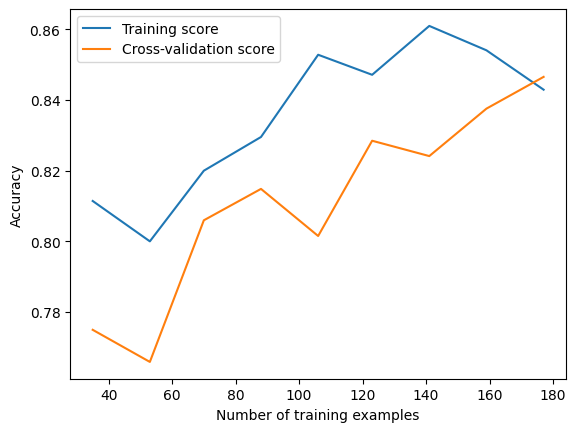

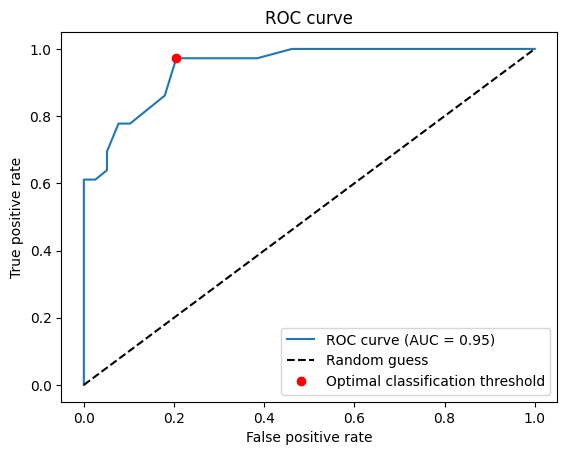

In [5]:
# Unregularized KNN

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import auc

print("Unregularized KNN")

# Hyperparameters to tune
params = {'n_neighbors': range(1, 31, 2), # start stop step
          'leaf_size': [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]}

# Unregularized KNN
knn_unreg = KNeighborsClassifier()

grid_unreg = GridSearchCV(knn_unreg, params, cv=5, n_jobs=-1)
grid_unreg.fit(X_train_scaled, y_train)
knn_unreg = grid_unreg.best_estimator_

print("Best hyperparameters: ", grid_unreg.best_params_)

# Get predicted probabilities for the test set
y_prob = grid_unreg.predict_proba(X_test_scaled)[:, 1]
# Compute false positive rate and true positive rate for different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# Calculate Euclidean distance to the top-left corner for each threshold
dist = np.sqrt(fpr**2 + (1-tpr)**2)
# Find index of threshold with minimum distance
idx = np.argmin(dist)
y_pred = (y_prob >= thresholds[idx]).astype(int)

print('Optimal classification threshold:', round(thresholds[idx], 2))

train_sizes, train_scores, test_scores = learning_curve(
    estimator=knn_unreg,
    X=X_train_scaled,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

printResults(knn_unreg, y_test, y_pred)

# Calculate means and standard deviations for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label="Training score")
#plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label="Cross-validation score")
#plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Compute AUC
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.plot(fpr[idx], tpr[idx], 'ro', label='Optimal classification threshold')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()

Regularized KNN
Best hyperparameters:  {'leaf_size': 1, 'n_neighbors': 11}
Optimal classification threshold: 0.46
Test set accuracy (% correct predicts): 0.92
Training set accuracy: 1.0
Balanced accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1-score: 0.92
Confusion matrix:
 [[35  4]
 [ 2 34]]
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.92        39
           1       0.89      0.94      0.92        36

    accuracy                           0.92        75
   macro avg       0.92      0.92      0.92        75
weighted avg       0.92      0.92      0.92        75



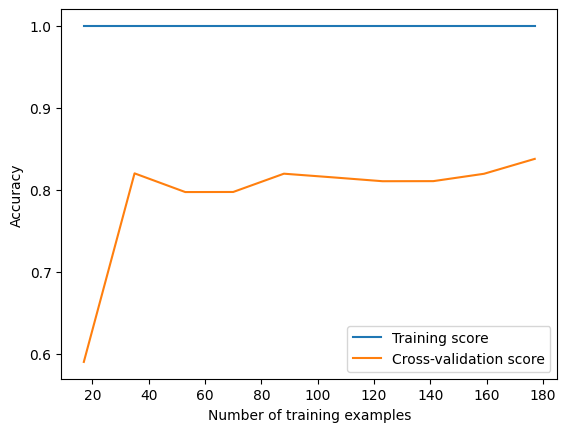

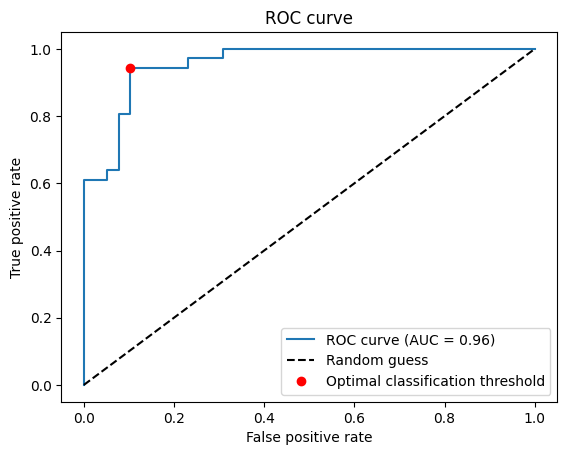

In [6]:
# Regularized KNN

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsClassifier

print("Regularized KNN")

# Hyperparameters to tune
params = {'n_neighbors': range(1, 31, 2), # start stop step
          'leaf_size': [1,2,3,4,5,10,20,30,40,50]}

knn_reg = KNeighborsClassifier(p=2, weights='distance')

grid_reg = GridSearchCV(knn_reg, params, cv=5, n_jobs=-1)
grid_reg.fit(X_train_scaled, y_train)
knn_reg = grid_reg.best_estimator_

print("Best hyperparameters: ", grid_reg.best_params_)

# Get predicted probabilities for the test set
y_prob = grid_reg.predict_proba(X_test_scaled)[:, 1]
# Compute false positive rate and true positive rate for different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# Calculate Euclidean distance to the top-left corner for each threshold
dist = np.sqrt(fpr**2 + (1-tpr)**2)
# Find index of threshold with minimum distance
idx = np.argmin(dist)
y_pred = (y_prob >= thresholds[idx]).astype(int)

print('Optimal classification threshold:', round(thresholds[idx], 2))
printResults(knn_reg, y_test, y_pred)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=knn_reg,
    X=X_train_scaled,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)


# Calculate means and standard deviations for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label="Training score")
#plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label="Cross-validation score")
#plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Compute AUC
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.plot(fpr[idx], tpr[idx], 'ro', label='Optimal classification threshold')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()